## Job Market Analysis Project
This project analyzes job market data to uncover trends, skills demand, and salary patterns using various Data Science and Machine Learning techniques.

**Objective:** Provide insights for job seekers and employers based on available datasets.

**Dataset:** Kaggle's job market dataset (2016)


## Problem statement

**Goal:** produce an actionable analysis of US job postings that (1) surfaces demand shifts in job roles and skills, and (2) models job categories where reliable labels exist — with an explicit focus on reproducibility and temporal generalization.

**Business questions:**
- Which job titles, skills, and sectors were most in-demand in 2016?
- What salary patterns exist, and how predictable are salaries from job posting fields?
- What biases or limitations does the dataset contain that affect conclusions?

**Scope & approach:**  
We use EDA and NLP (title + description processing), then build regression models (baseline → tree-based) to predict job categories. All modeling will use **time-aware validation** and careful label construction to avoid misleading results.

Data Source:
* **2016:** [Monster.com Job Postings Dataset](https://www.kaggle.com/datasets/PromptCloudHQ/us-jobs-on-monstercom )  



## Data dictionary

| Column name | Type | Description |
|-------------|------|-------------|
| `job_id` | string | Unique identifier for the posting (if available) |
| `company` | string | Employer name |
| `title` | string | Job title from the posting |
| `location` | string | Full location string (city, state) |
| `description` | string | Full job description text |
| `salary` | string/var | Raw salary string as scraped (may be range, hourly, or missing) |
| `date_added` | datetime | Date the job was posted (or scraped) |
| `job_type` | string | Full-time/part-time/contract (if available) |
| `category` | string | Job category or industry tag (if available) |

**Notes:**  
- Some rows do not include salary information. We will create a derived numeric `salary_annual` and flags describing the salary source/type.  
- We will standardize `location` to `city, state` and create `state` flags.


##Imports

In [1]:
# Install NLTK only if not available
try:
    import nltk
except ImportError:
    !pip install nltk

import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Core EDA + preprocessing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud


### Initial data checks and EDA goals

Goals for this section:
1. Understand data shapes and missingness.
2. Detect labelling issues for salary (ranges, hourly, non-US currency).
3. Inspect distributions for title frequency, location, and salary (where available).


In [3]:
# Load data
df = pd.read_csv("monster_com-job_sample.csv", parse_dates=["date_added"], low_memory=False)

# View first 10 rows
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
display(df.head(10))  # show first 10 rows for better feel

Dataset contains 22000 rows and 14 columns.



,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
0,United States of America,US,NaT,No,jobs.monster.com,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,Full Time Employee,"Madison, WI 53702",NaN,http://jobview.monster.com/it-support-technici...,NaN,IT/Software Development,11d599f229a80023d2f40e7c52cd941e
1,United States of America,US,NaT,No,jobs.monster.com,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,Full Time,"Madison, WI 53708",Printing and Publishing,http://jobview.monster.com/business-reporter-e...,NaN,NaN,e4cbb126dabf22159aff90223243ff2a
2,United States of America,US,NaT,No,jobs.monster.com,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,"Full Time, Employee",DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,http://jobview.monster.com/senior-training-lea...,NaN,NaN,839106b353877fa3d896ffb9c1fe01c0
3,United States of America,US,NaT,No,jobs.monster.com,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,Full Time,"Dixon, CA",Altec Industries,http://jobview.monster.com/engineer-quality-jo...,NaN,Experienced (Non-Manager),58435fcab804439efdcaa7ecca0fd783
4,United States of America,US,NaT,No,jobs.monster.com,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,Full Time Employee,"Camphill, PA",Retail,http://jobview.monster.com/shift-supervisor-pa...,NaN,Project/Program Management,64d0272dc8496abfd9523a8df63c184c
5,United States of America,US,NaT,No,jobs.monster.com,Job Description Job #: 720298Apex Systems has...,Construction PM - Charlottesville Job in Charl...,Full Time Employee,"Charlottesville, VA",Computer/IT Services,http://jobview.monster.com/construction-pm-cha...,NaN,Experienced (Non-Manager),1e2637cb5f7a2c4615a99a26c0566c66
6,United States of America,US,NaT,No,jobs.monster.com,Report this job About the Job Based in San Fra...,CyberCoders Job Application for Principal QA E...,"Full Time, Employee",Contact name Tony Zerio,Computer Software,http://jobview.monster.com/principal-qa-engine...,NaN,NaN,455802d725fde67293970ab3953b1d39
7,United States of America,US,NaT,No,jobs.monster.com,RESPONSIBILITIES:Kforce has a client seeking a...,Mailroom Clerk Job in Austin,Full Time Employee,"Austin, TX 73301",NaN,http://jobview.monster.com/mailroom-clerk-job-...,NaN,Experienced (Non-Manager),549a0541e4452ecd155efc032aaa72d7
8,United States of America,US,NaT,No,jobs.monster.com,"Part-Time, 4:30 pm - 9:30 pm, Mon - Fri Brookd...",Housekeeper Job in Austin,Part Time Employee,"Austin, TX 78746",Hotels and Lodging Personal and Household Serv...,http://jobview.monster.com/housekeeper-job-aus...,NaN,Customer Support/Client Care,a6a2b5e825b8ce1c3b517adb2497c5ed
9,United States of America,US,NaT,No,jobs.monster.com,"Insituform Technologies, LLC, an Aegion compan...",Video Data Management /Transportation Technici...,NaN,"Chesterfield, MO",NaN,http://jobview.monster.com/video-data-manageme...,NaN,NaN,73a9ba2b706e02628fa22ca1357174b1


Columns with missing values: 5 / 14


,missing,pct
date_added,21878,99.45
salary,18554,84.34
organization,6867,31.21
sector,5194,23.61
job_type,1628,7.40


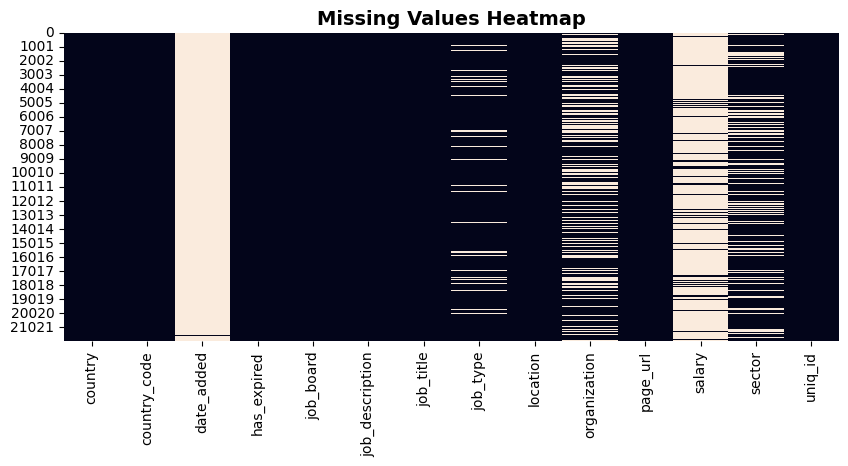

In [4]:
#Missing values analysis
missing = df.isnull().sum().sort_values(ascending=False)
missing_nonzero = missing[missing > 0]
print("Columns with missing values:", len(missing_nonzero), "/", df.shape[1])
display(missing_nonzero.to_frame("missing").assign(
    pct=lambda x: (x["missing"] / len(df) * 100).round(2)
))

plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap",fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()


In [5]:
#gain insight into the data
df.info()

print("\nSummary statistics for categorical columns:\n")
display(df.describe(include=[object]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   country          22000 non-null  object        
 1   country_code     22000 non-null  object        
 2   date_added       122 non-null    datetime64[ns]
 3   has_expired      22000 non-null  object        
 4   job_board        22000 non-null  object        
 5   job_description  22000 non-null  object        
 6   job_title        22000 non-null  object        
 7   job_type         20372 non-null  object        
 8   location         22000 non-null  object        
 9   organization     15133 non-null  object        
 10  page_url         22000 non-null  object        
 11  salary           3446 non-null   object        
 12  sector           16806 non-null  object        
 13  uniq_id          22000 non-null  object        
dtypes: datetime64[ns](1), object(13)
memor

,country,country_code,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
count,22000,22000,22000,22000,22000,22000,20372,22000,15133,22000,3446,16806,22000
unique,1,1,1,1,18744,18759,39,8423,738,22000,1737,163,22000
top,United States of America,US,No,jobs.monster.com,12N Horizontal Construction Engineers Job Desc...,Monster,Full Time,"Dallas, TX",Healthcare Services,http://jobview.monster.com/Custodian-Lead-Job-...,"40,000.00 - 100,000.00 $ /year",Experienced (Non-Manager),1d37a888ca65fd919e459147a4c33457
freq,22000,22000,22000,22000,104,318,6757,646,1919,1,50,4594,1


**Findings:**

- Total rows in data: 22000
- Features with only 1 unique entry: country, country_code, has_expired, job_board.
- These features will not be able to help us determine anything about the job market or trends due to there being a lack of unique values. These columns will later be dropped when creating models

In [6]:
# Column types and missingness summary
print("\nColumn types:")
display(df.dtypes)



Column types:


,0
country,object
country_code,object
date_added,datetime64[ns]
has_expired,object
job_board,object
job_description,object
job_title,object
job_type,object
location,object
organization,object


Total columns with missing values: 5 / 14


,0
date_added,99.445455
salary,84.336364
organization,31.213636
sector,23.609091
job_type,7.400000
country,0.000000
job_description,0.000000
job_board,0.000000
has_expired,0.000000
country_code,0.000000


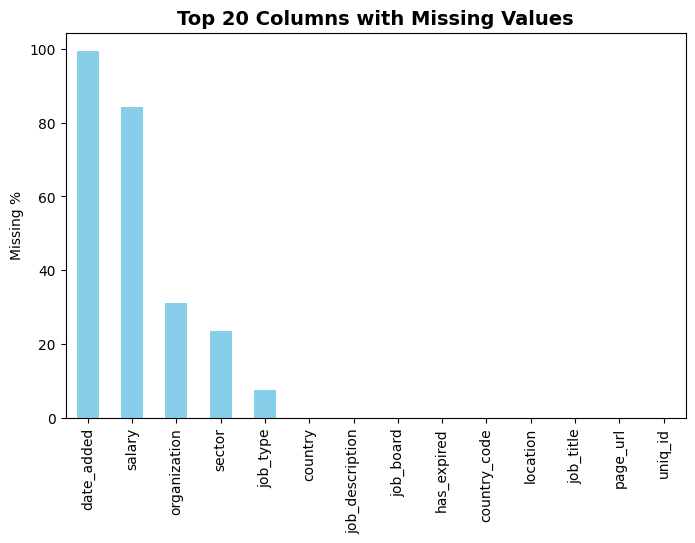

In [7]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print(f"Total columns with missing values: {(missing_pct > 0).sum()} / {df.shape[1]}")

# Display top 20
display(missing_pct.head(20))

# Optional: Visualize missingness
plt.figure(figsize=(8, 5))
missing_pct.head(20).plot(kind='bar', color='skyblue')
plt.ylabel("Missing %")
plt.title("Top 20 Columns with Missing Values",fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()



Findings:
- After understanding the data types, and percentage of data missing in each field, continue to inspect the data and prepare to clean and adjust data fields
- Based on the results above regarding the percentage of data missing in each field, the top missing features in the data are date_added, salary, and organization.
-The date_added column is not signifcant to this problem as we are not worried about when the job was posted we know this data was from the year 2016

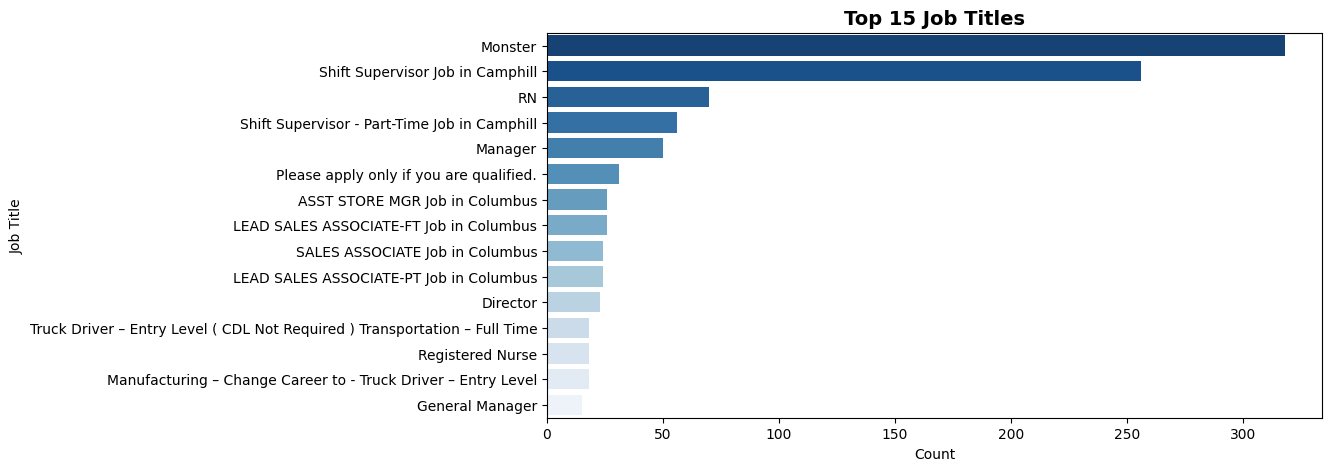


Top 10 companies:


,count
organization,
Healthcare Services,1919
All,1158
Retail,1081
Other/Not Classified,1048
Manufacturing - Other,885
Computer/IT Services,822
Legal Services,466
Business Services - Other,410
Restaurant/Food Services,384


In [8]:
# Basic counts for key fields
# After
top_jobs = df['job_title'].value_counts().head(15)
plt.figure(figsize=(10,5))
sns.barplot(x=top_jobs.values, y=top_jobs.index, palette="Blues_r", hue = top_jobs.index, legend=False)
plt.title("Top 15 Job Titles",fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Count")
plt.ylabel("Job Title")
plt.show()


print("\nTop 10 companies:")
display(df['organization'].value_counts().head(10))



Posted date range: 2016-02-29 00:00:00 to 2017-01-16 00:00:00


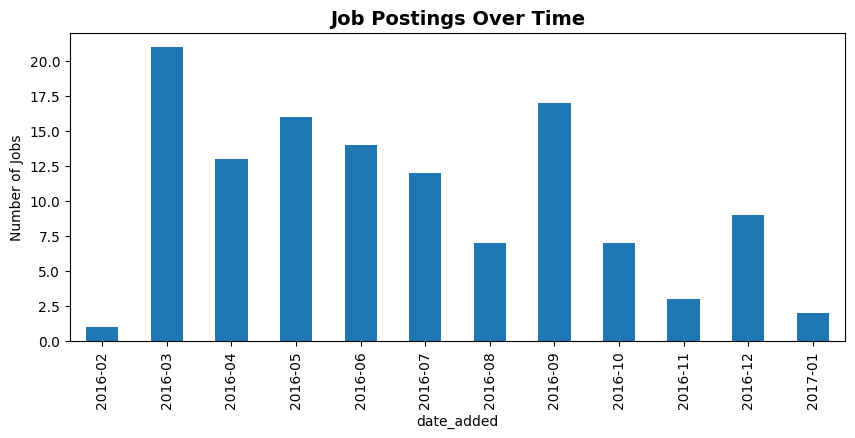

Salary column missing 84.34% of values.

Sample raw salary values:


,salary
17660,17.00 - 21.00 /hour
13812,"60,000.00 - 75,000.00 $ /yearDOE - Negotiable"
17394,BOE
17710,"$25,000.00+ /yearAdditional Spiffs"
8919,Commensurate with Experience
4386,"0.00 - 75,000.00 $ /year"
1745,"50,000.00 - 65,000.00 $ /year"
2566,"40,000.00 - 55,000.00 $ /year"
6921,"85,000.00 - 110,000.00 $ /year"
13463,"$65,000.00+ /year"


In [9]:
# If posted_date exists: show date range
if 'date_added' in df.columns:
    print("\nPosted date range:", df['date_added'].min(), "to", df['date_added'].max())

    plt.figure(figsize=(10,4))
    df['date_added'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')
    plt.title("Job Postings Over Time",fontdict={'fontsize': 14, 'fontweight': 'bold'})
    plt.ylabel("Number of Jobs")
    plt.show()


# Quick salary raw sample for inspection
if 'salary' in df.columns:
    salary_missing_pct = df['salary'].isna().mean() * 100
    print(f"Salary column missing {salary_missing_pct:.2f}% of values.")
    print("\nSample raw salary values:")
    display(df['salary'].dropna().sample(min(10, len(df['salary'].dropna())), random_state=0))

else:
    print("\nNo salary column found.")

**Findings:**  
- Record percent missing for salary and any non-standard formats observed (ranges, hourly rates).   
- Note the top job titles and companies (high cardinality fields that may need aggregation).
- Not many jobs posted have dates will have to focus more towards the job_title and job_description fields (categorical problem).


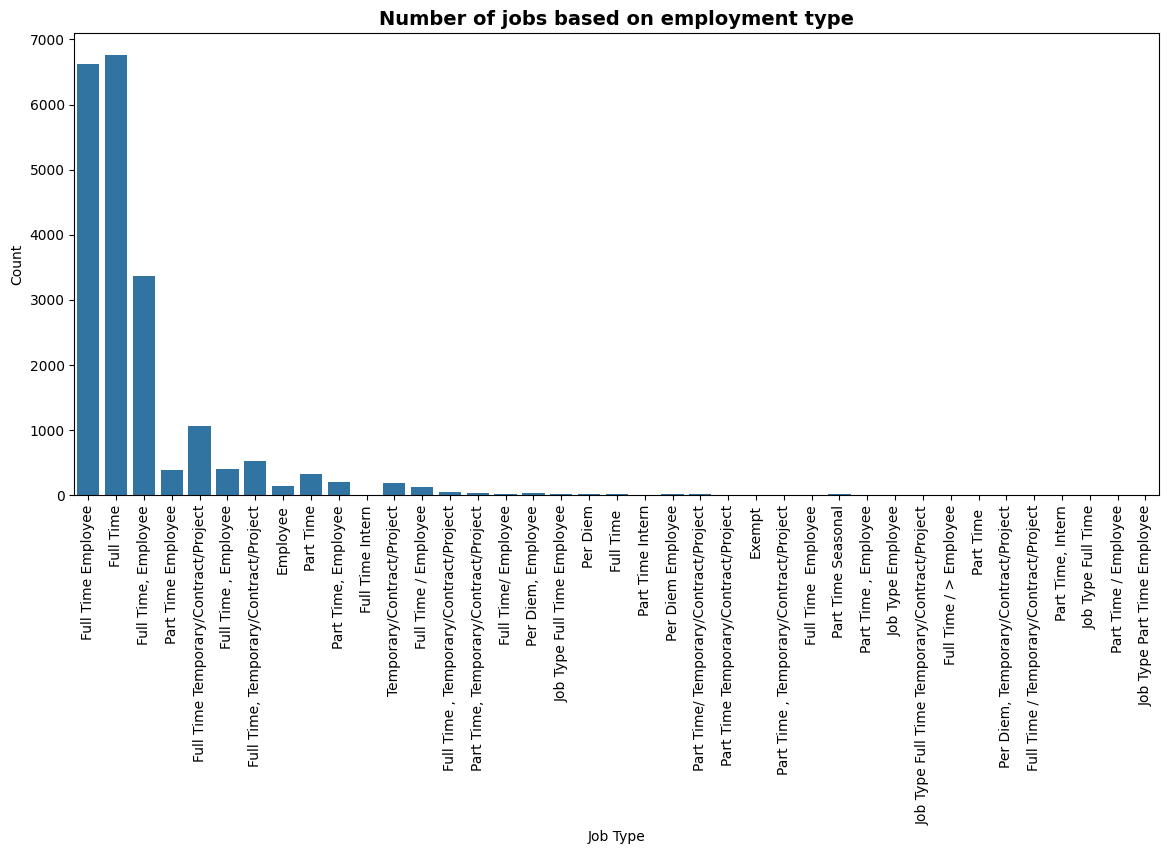

In [10]:
#Create plot based on employment types
plt.figure(figsize=(14,6))
sns.countplot(x='job_type', data=df)
plt.title('Number of jobs based on employment type', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Job Type')
plt.xticks(rotation=90)
plt.ylabel('Count')

plt.show()

**Findings:**

- Majority of the jobs being posted are Full Time positions with a small portion of positions being temporary or part time.

In [11]:
#Dropping columns that have no unique values
cols_to_drop = ['country', 'country_code', 'has_expired', 'job_board']
drop_existing = [col for col in cols_to_drop if col in df.columns]
df.drop(columns=drop_existing, inplace=True)
print(f"Dropped columns: {drop_existing}")


Dropped columns: ['country', 'country_code', 'has_expired', 'job_board']


Drop missing rows in ['country', 'country_code', 'has_expired', 'job_board'] fields since if they are missing it won't help us achieve our goals outlined in the problem statement. For classification it will not matter if the job has expired, what country the country code and what job board the position is from. Since all the positions are from monster jobs and all are from 2016 and located within the USA these factors will not play any significant role in determining the job_title.

###Filtering Location to get Region

In [12]:
#take location and extract the state to create region feature
locations = df['location']
state_location = []
for x in range(len(locations)):

        if locations.get(x) != None:
                location = locations.get(x)
                location = str(location)
                area = location.split(',')
                state = area[len(area)-1]
                if(state[1:3].isupper()):
                        state_location.append(state[1:3])
                else:
                        state_location.append('N/A')
        else:
                state_location.append('N/A')

In [13]:
#create the state feature in the dataframe
df['state']= state_location

In [14]:
#Classify the states into their respective regions
state_regions = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West Coast',
    'CO': 'West', 'CT': 'Northeast', 'DE': 'South', 'FL': 'South', 'GA': 'South',
    'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'KY': 'South', 'LA': 'South', 'ME': 'Northeast', 'MD': 'South',
    'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South', 'MO': 'Midwest',
    'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast',
    'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest',
    'OK': 'South', 'OR': 'West Coast', 'PA': 'Northeast', 'RI': 'Northeast',
    'SC': 'South', 'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West',
    'VT': 'Northeast', 'VA': 'South', 'WA': 'West Coast', 'WV': 'South',
    'WI': 'Midwest', 'WY': 'West', 'DC': 'Northeast'
}

In [15]:
# Strip whitespace and make uppercase just in case
import re

# Extract the 2-letter state abbreviation using regex
df['state'] = df['location'].str.extract(r',\s*([A-Z]{2})\s*\d{0,5}')


# Map states to regions
df['region'] = df['state'].map(state_regions)

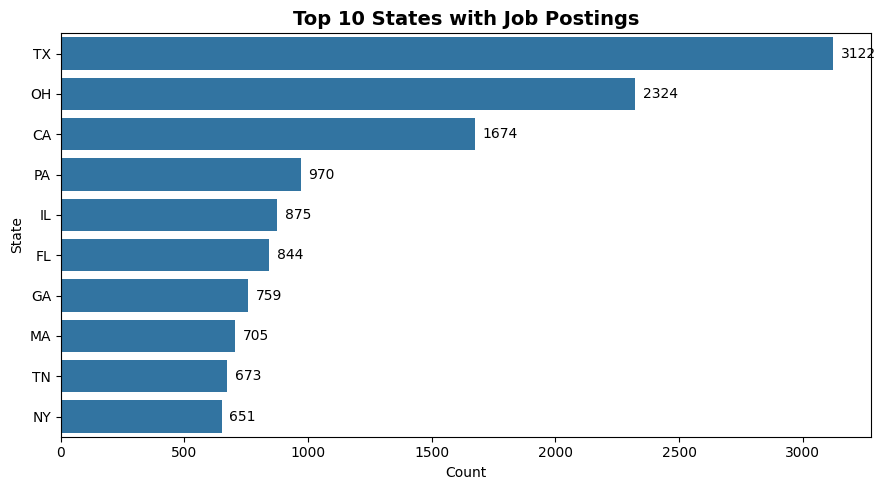

In [16]:
import re

def split_location(loc):
    if pd.isna(loc):
        return pd.Series([None, None])
    s = str(loc).strip()
    # If there's a comma, split as "City, ST"
    if "," in s:
        city, rest = s.split(",", 1)
        state_raw = rest.strip()
    else:
        city, state_raw = None, s  # handle formats like "TX 75201"
    # Extract 2-letter state code
    m = re.search(r"\b([A-Za-z]{2})\b", str(state_raw).upper())
    state = m.group(1).upper() if m else None
    city = None if city is None else city.strip()
    return pd.Series([city, state])

df[['city','state']] = df['location'].astype(str).apply(split_location)

def normalize_state(x):
    if pd.isna(x):
        return None
    x = str(x).strip().upper()
    m = re.match(r"^([A-Z]{2})", x)
    return m.group(1) if m else None

df['state'] = df['state'].apply(normalize_state)

valid_states = set("""AL AK AZ AR CA CO CT DE FL GA HI ID IL IN IA KS KY LA ME MD MA MI MN
MS MO MT NE NV NH NJ NM NY NC ND OH OK OR PA RI SC SD TN TX UT VT VA WA WV WI WY DC""".split())
df['state_clean'] = df['state'].where(df['state'].isin(valid_states))
top_states = df['state_clean'].value_counts().head(10)

plt.figure(figsize=(9, 5))
ax = sns.barplot(x=top_states.values, y=top_states.index)
ax.set_title("Top 10 States with Job Postings", fontsize=14, weight="bold")
ax.set_xlabel("Count")
ax.set_ylabel("State")

# Add value labels
for i, v in enumerate(top_states.values):
    ax.text(v + max(top_states.values)*0.01, i, str(int(v)), va='center')

plt.tight_layout()
plt.show()


**Findings:**
- Texas has the most job postings
- Location field now split up to gain a better insight into the data

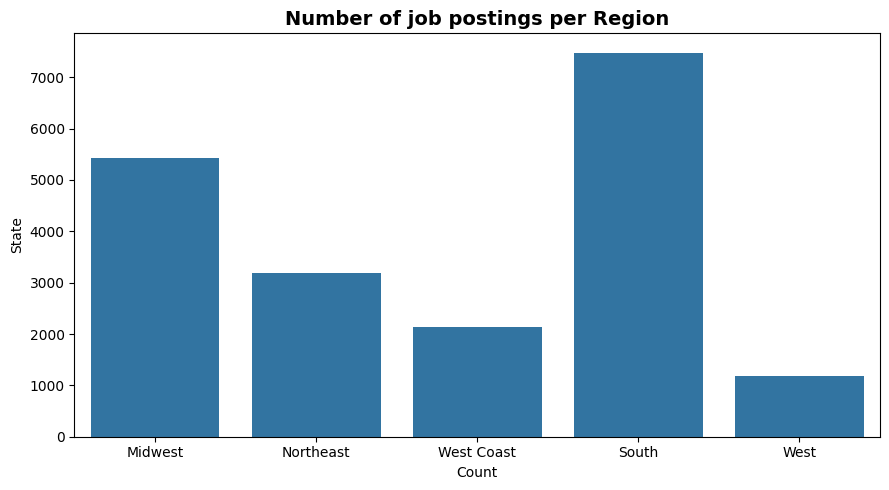

In [17]:
#Number of jobs based on region
plt.figure(figsize=(9, 5))
ax = sns.countplot(x='region', data = df)
ax.set_title("Number of job postings per Region", fontsize=14, weight="bold")
ax.set_xlabel("Count")
ax.set_ylabel("State")
plt.tight_layout()
plt.show()


**Findings:**
- Most jobs are located within the South and Midwest
- This could mean the Monster website is a primary source for employing in these regions
- Could also mean that these locations are growing and have more openings than the other regions

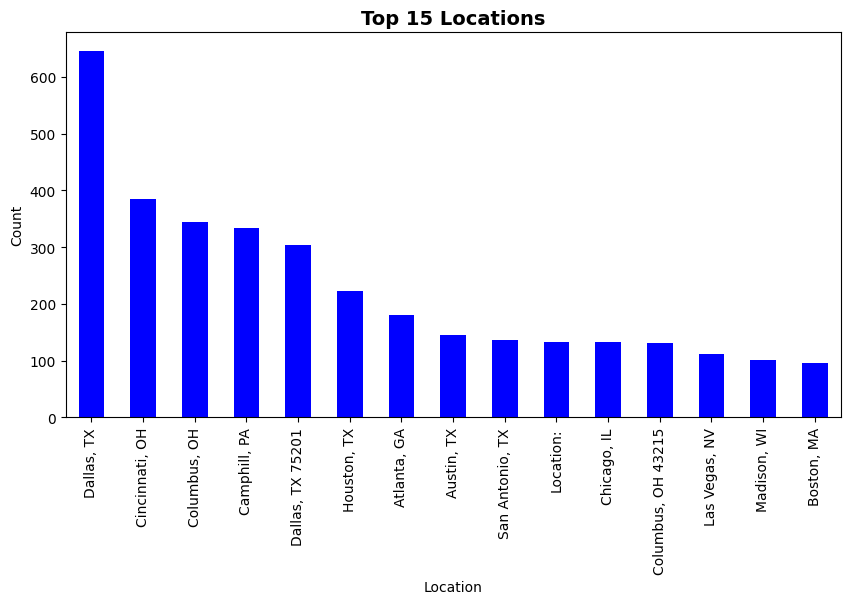

In [18]:
#Top locations posted
plt.figure(figsize=(10,5))
df['location'].value_counts().head(15).plot(kind='bar', color='blue')
plt.title("Top 15 Locations", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()


**Findings:**

- Dallas is the city with the most job postings can notice that some of the cities are major cities, dallas, houstan, atlanta, las vegas, boston etc.
- Large cities have more companies looking to hire and wanting to expand.

###Filtering job_titles into job_category
I want to change this to check skills

In [19]:
#Taking the job_titles and extracting the field ex. tech, healthcare
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_title(title):
    words = word_tokenize(str(title).lower())
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmas)


In [20]:
#Extract specific titles and create a new field lemmatized_title
df['lemmatized_title'] = df['job_title'].apply(lemmatize_title)

In [21]:
#create job categories can be changed in future to expand for other jobs that might not be captured
job_categories = {
    'developer': 'Technology',
    'software': 'Technology',
    'engineer': 'Technology',
    'it': 'Technology',
    'data': 'Technology',
    'nurse': 'Healthcare',
    'health': 'Healthcare',
    'hospital': 'Healthcare',
    'medical': 'Healthcare',
    'teacher': 'Education',
    'professor': 'Education',
    'accountant': 'Finance',
    'finance': 'Finance',
    'analyst': 'Business',
    'manager': 'Business',
    'sales': 'Sales',
    'marketing': 'Marketing',
    'customer': 'Customer Service',
    'support': 'Customer Service',
    'warehouse': 'Logistics',
    'driver': 'Logistics',
    'mechanic': 'Trades',
    'construction': 'Trades',
    'electrician': 'Trades',
    'plumber': 'Trades',
    'recruiter': 'Human Resources',
    'hr': 'Human Resources',
    'lawyer': 'Legal',
    'attorney': 'Legal'
}


In [22]:
#mapping the lemmatized_title to job_category
def map_category(title):
    title = str(title).lower()
    for keyword, category in job_categories.items():
        if keyword in title:
            return category
    return 'Other'  # Default if no keyword matched

df['job_category'] = df['lemmatized_title'].apply(map_category)


Mapping the job_title field into job_category to get a better idea of what industries are looking to hire based on the title of the job

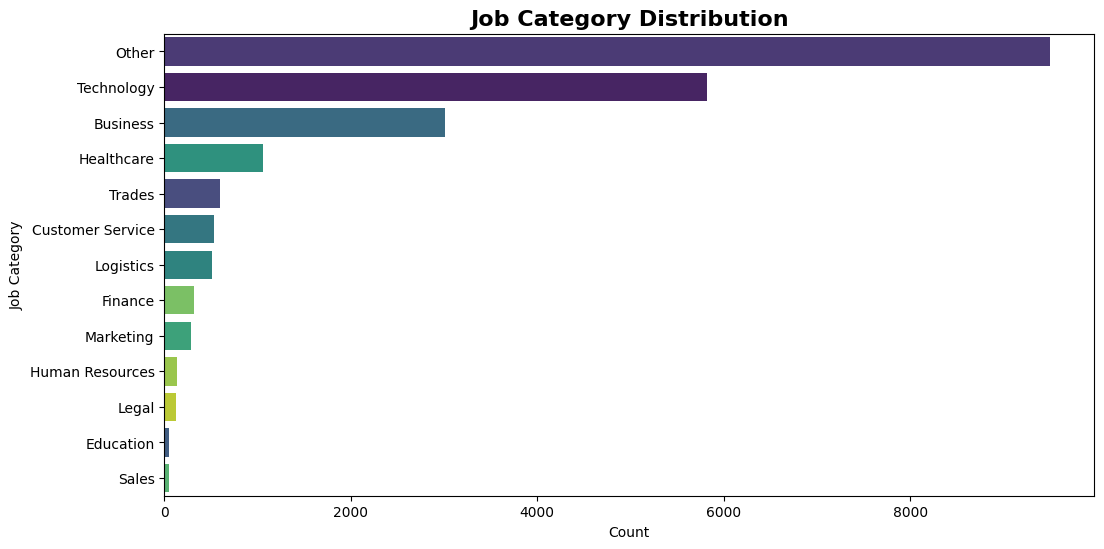

In [23]:
#plotting the count of job categories
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='job_category', order=df['job_category'].value_counts().index, palette='viridis', hue = 'job_category', legend=False)
plt.title('Job Category Distribution', fontdict={'fontsize': 16, 'fontweight': 'bold'} )
plt.xlabel('Count')
plt.ylabel('Job Category')
plt.show()


**Findings:**
- Besides other, Technology and Business have the most job postings with sales and education having the least
- Reasons could be that previous years hired more Education workers and sales workers and no longer need as many, could also be an indication of industry trends.
- As technology evolves, new business are able to form creating an increase for both tech and business workers.
- Question: How long will these growing/booming industries last?

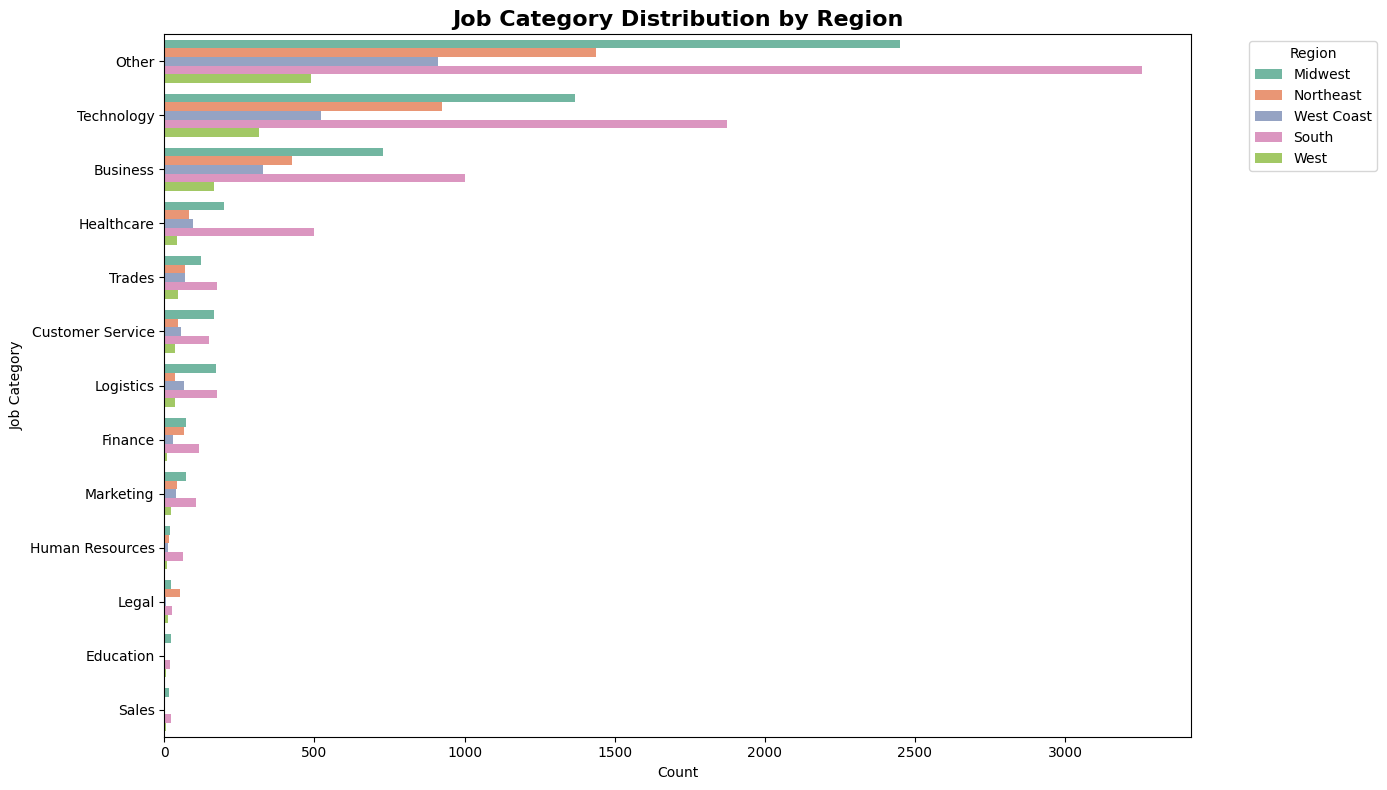

In [24]:
#number of jobs in each region based upon the job field
plt.figure(figsize=(14,8))
sns.countplot(data=df, y='job_category', hue='region', order=df['job_category'].value_counts().index, palette='Set2')
plt.title('Job Category Distribution by Region', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Count')
plt.ylabel('Job Category')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Findings:**

- While the Southern region has most of the job postings, the Midwestern region has more positions within the customer service, trades, logistics and sales industries.
- This can indicate a growth/developement in different regions. For example, the northeast is very established within the Tech and business fields, so they may not need to hire as many people as a growing or developing region such as the South.
- As a region develops, more people need to be hired to fill positions. Reasons a region may be developing could be from cost of business operating in other states. For example, cost of operating in California is more expensive than the cost of operating in Texas.

###Converting Salaries to all be average yearly salary

In [25]:
# Helper function to parse salary
def parse_salary(s):
    if pd.isna(s) or 'Not Specified' in s:
        return pd.Series([None, None, None])

    # Remove commas and dollar signs
    s_clean = s.replace(',', '').replace('$', '')

    # Match patterns like "50000 - 70000", "9.00 - 13.00", "60000/year"
    match = re.findall(r'(\d+(?:\.\d+)?)', s_clean)

    if len(match) == 1:
        min_sal = max_sal = float(match[0])
    elif len(match) >= 2:
        min_sal, max_sal = float(match[0]), float(match[1])
    else:
        return pd.Series([None, None, None])

    # Detect if it's hourly/monthly/yearly
    if 'hour' in s.lower():
        period = 'hour'
    elif 'month' in s.lower():
        period = 'month'
    else:
        period = 'year'

    return pd.Series([min_sal, max_sal, period])


In [26]:
#Parsing the salary from the dataframe
salary = df['salary'].apply(parse_salary)

In [27]:
#Get an idea of what the salaries look like
print(salary)

              0         1     2
0           NaN       NaN  None
1           NaN       NaN  None
2           NaN       NaN  None
3           NaN       NaN  None
4           NaN       NaN  None
...         ...       ...   ...
21995  120000.0  160000.0  year
21996   45000.0   60000.0  year
21997       NaN       NaN  None
21998      25.0      28.0  hour
21999   40000.0   46000.0  year

[22000 rows x 3 columns]


**Findings:**
- As noticed before salary has a lot of missing information which makes us unable to use this data when creating machine learning models
- However, we can look at the information from what is there and draw inferences based on what is given

In [28]:
#Creating separate columns for each of the pieces extracted
df['salary_min'] = salary[0]
df['salary_max'] = salary[1]
df['salary_means'] = salary[2]

In [29]:
#Normalizing the salary data so that the data is consistent
def normalize_salary(row):
    if row['salary_means'] == 'hour':
        return row['salary_min'] * 2080, row['salary_max'] * 2080
    elif row['salary_means'] == 'month':
        return row['salary_min'] * 12, row['salary_max'] * 12
    else:
        return row['salary_min'], row['salary_max']



In [30]:
#Creating new columns for yearly salary
df[['min_salary_yearly', 'max_salary_yearly']] = df.apply(normalize_salary, axis=1, result_type='expand')

In [31]:
#Making salary bins for the visualizations
df['salary_bin'] = df['max_salary_yearly'] // 5000 * 5000  # bucket into $5k bins


In [32]:
#Getting the top salary bins
salary_counts = df['salary_bin'].value_counts().sort_index()
bins = salary_counts.head(15)


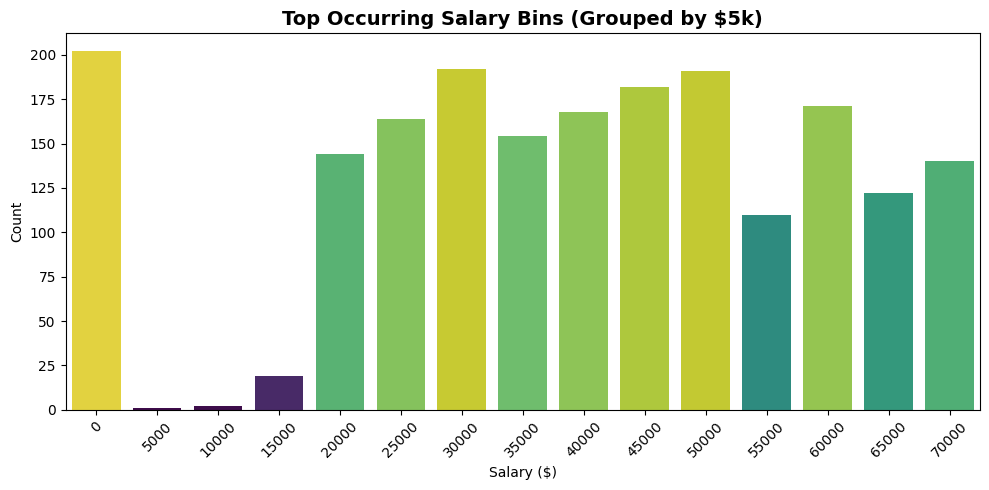

In [33]:
#Creating a plot of salary bins
plt.figure(figsize=(10, 5))
sns.barplot(x=bins.index.astype(int), y=bins.values, palette='viridis', hue= bins.values, legend= False)
plt.title("Top Occurring Salary Bins (Grouped by $5k)", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Salary ($)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Findings:**
- There are some positions with no listed salary, this could be unpaid positions, such as unpaid internships or these could be posts that did not include the salary/pay.
- Positions listed with low salaries could indicate positions with a percentage of sales which would not be included in this information such as a car salesman.
- This could also give us insight into minimum wages and pay across various states/regions and pay depending on indemand skills.

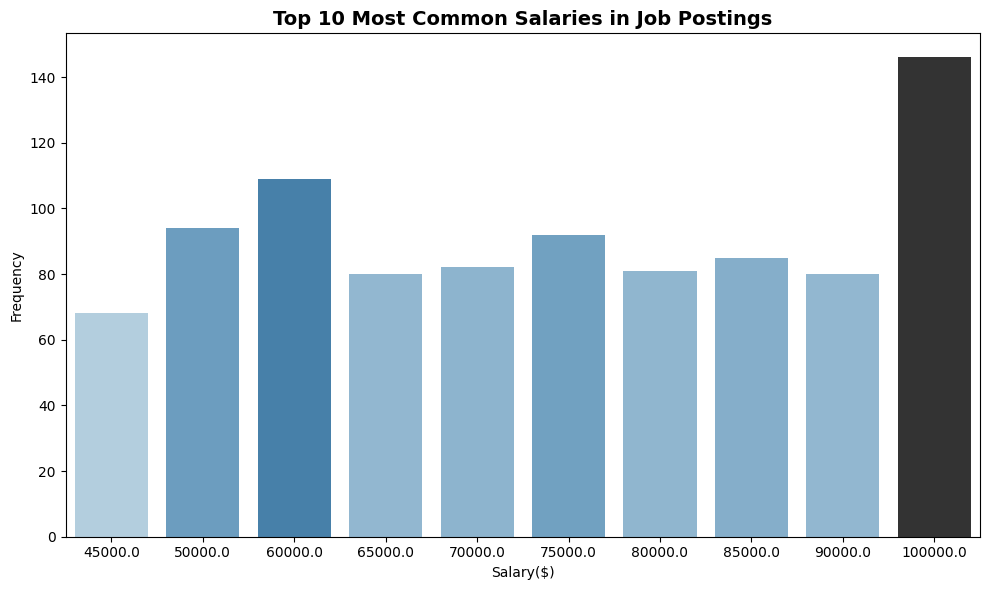

In [34]:
#visualize the top salaries
top_salaries = df['max_salary_yearly'].value_counts().nlargest(10)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_salaries.index, y=top_salaries, palette="Blues_d", hue = top_salaries, legend=False)
plt.xlabel("Salary($)")
plt.ylabel("Frequency")
plt.title("Top 10 Most Common Salaries in Job Postings", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()

**Findings:**
- Based on this visualization there is a spike in jobs at 100k salary with 140 people, and the next most common salary being 60k, this can be an indication that the positions require certain experience and skill sets that pay more
- This could also be an indication of inflation or the cost of living is increasing in the locations where these jobs were posted.

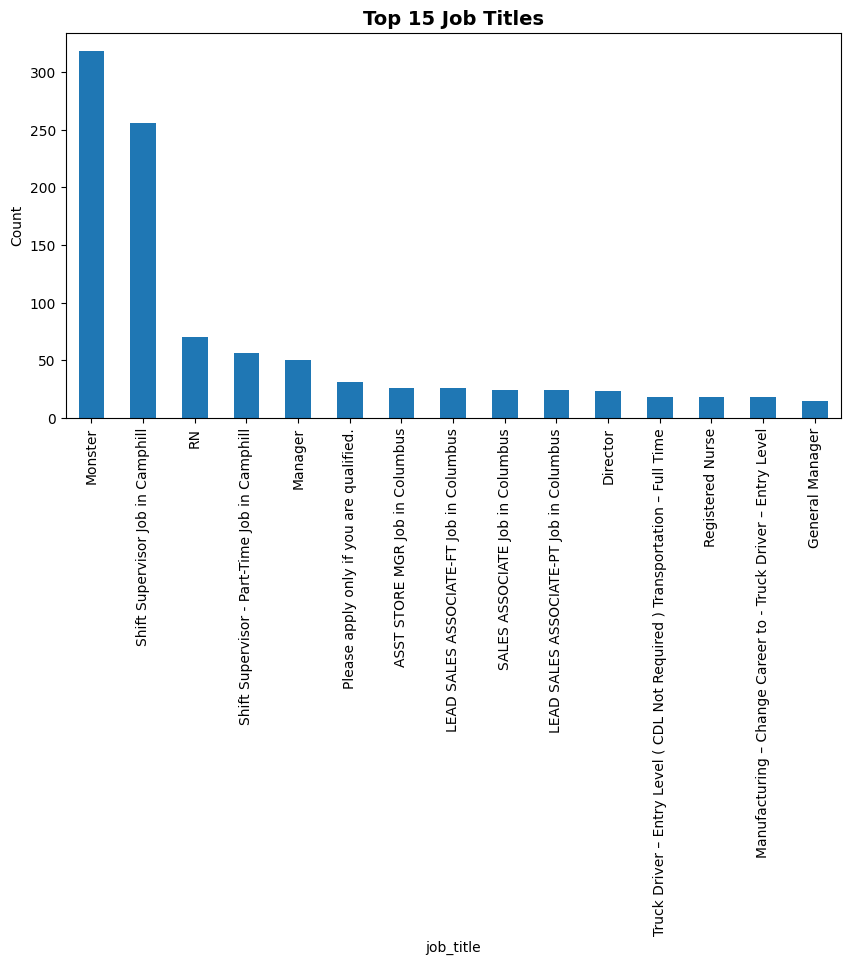

In [35]:
plt.figure(figsize=(10,5))
df['job_title'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Job Titles", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel("Count")
plt.show()


**Findings:**
- Employers did not correctly fill out the job posting since most jobs are with the title Monter.

- This could result in bias when trying to use the job_title to predict another field.

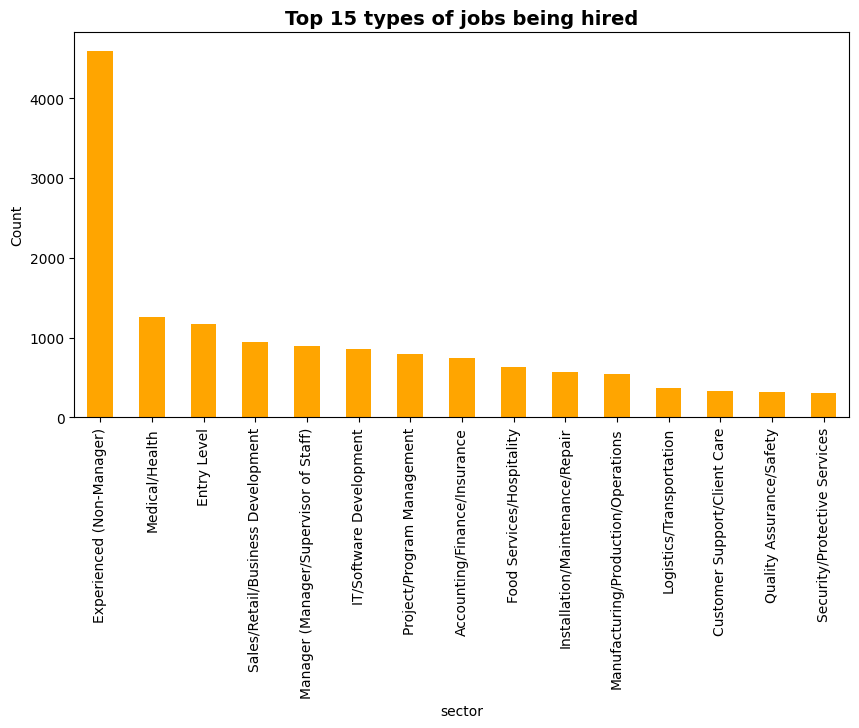

In [36]:
plt.figure(figsize=(10,5))
df['sector'].value_counts().head(15).plot(kind='bar', color='orange')
plt.title("Top 15 types of jobs being hired", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel("Count")
plt.show()


**Findings:**
- Most of the positions are for experienced workers, not as many entry/college-grad postions.
- Other industries seem to have a decent amount of postings
- Data is skewed heavily towards experienced workers

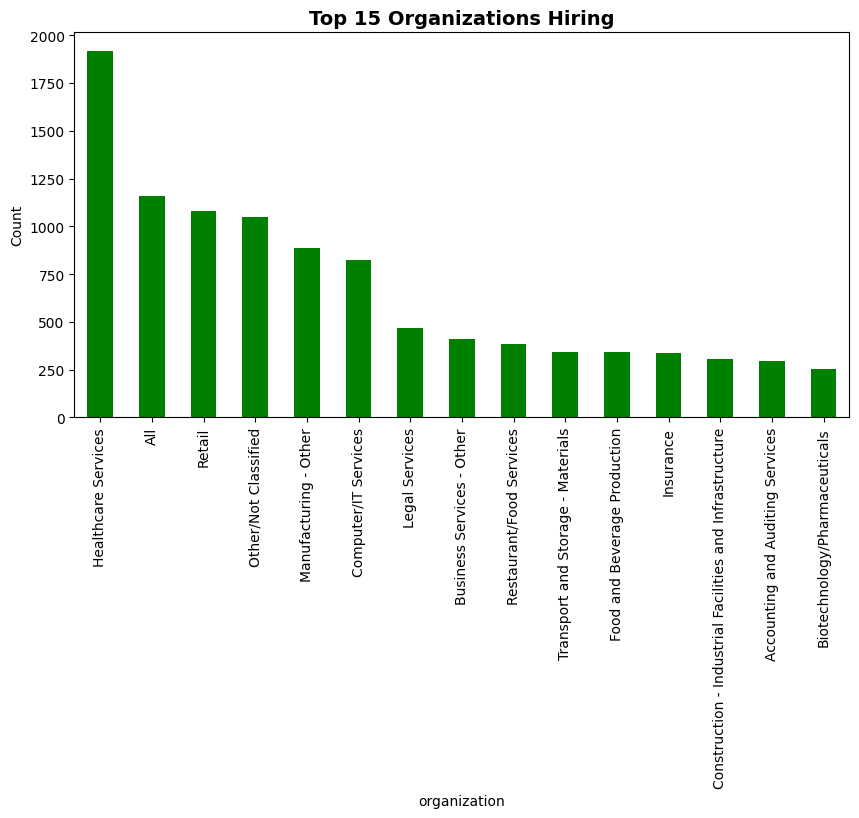

In [37]:
plt.figure(figsize=(10,5))
df['organization'].value_counts().head(15).plot(kind='bar', color='green')
plt.title("Top 15 Organizations Hiring", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel("Count")
plt.show()

**Findings:**
- Seems as if companies have confused organization and sector and filled out the same information, this can also be from how the data was gathered.
- Health industry seems to be hiring the most people, could be an indemand field and can be due to people living longer

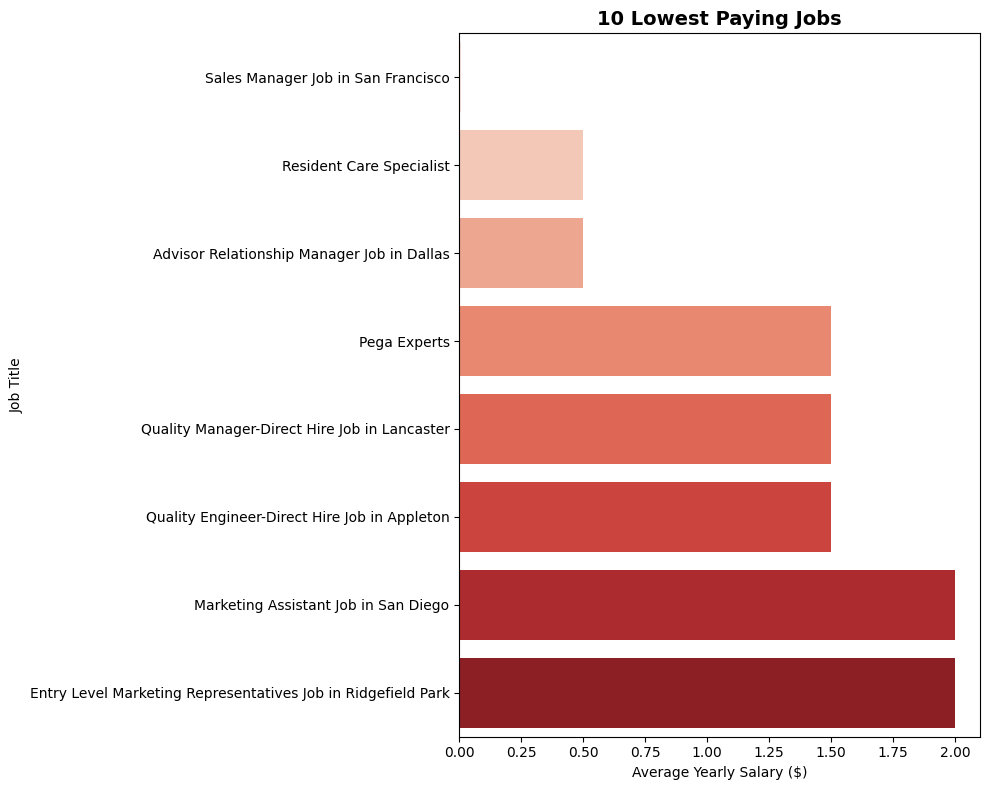

In [38]:

# Step 1: Compute average salary for each job
df['avg_salary'] = df[['min_salary_yearly', 'max_salary_yearly']].mean(axis=1)

# Step 2: Drop rows where avg_salary is missing
df_salary_clean = df.dropna(subset=['avg_salary'])

# Step 3: Get 10 lowest average salaries
lowest_salaries = df_salary_clean.nsmallest(10, 'avg_salary')

# Step 4: Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=lowest_salaries, x='avg_salary', y='job_title', palette='Reds', hue = 'job_title', legend= False)
plt.xlabel("Average Yearly Salary ($)")
plt.ylabel("Job Title")
plt.title("10 Lowest Paying Jobs", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()


**Findings:**
- The lowest paying jobs don't seem to have any correlation with specific job markets or industries.
- These jobs could have been posted incorrectly or employers may be offering other incentives to make up this pay.

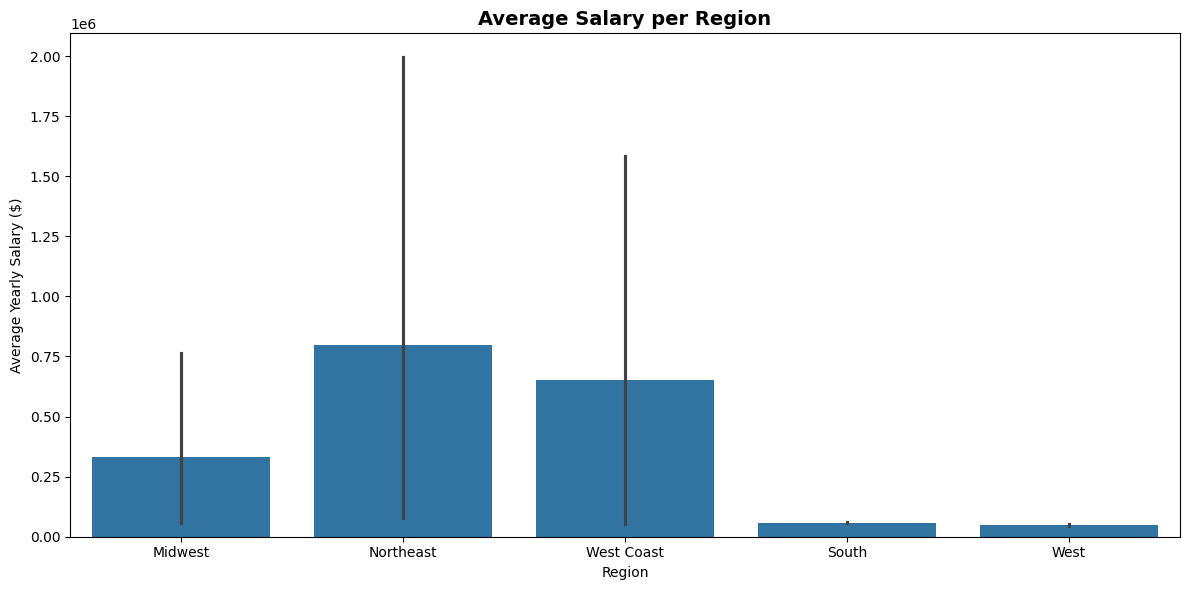

In [39]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='region', y='avg_salary')
plt.xlabel("Region")
plt.ylabel("Average Yearly Salary ($)")
plt.title("Average Salary per Region", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()

**Findings:**
- Northeast has the highest salaries ranging to almost 200k for positions, Westcoast region also is fairly high.
- Majority of salaries are under 100k

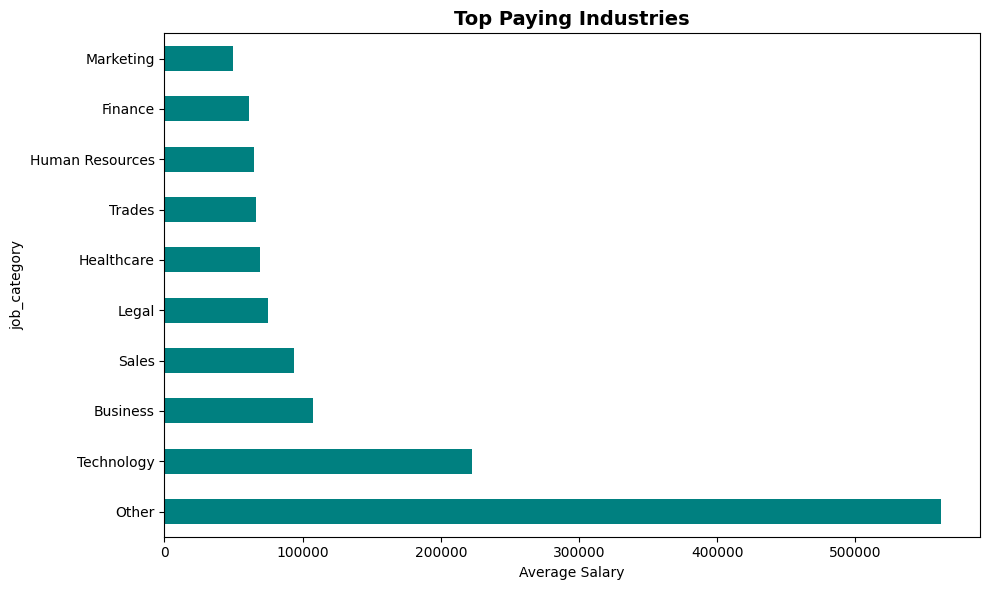

In [40]:
top_industries = df.groupby('job_category')['avg_salary'].mean().sort_values(ascending=False).head(10)
top_industries.plot(kind='barh', figsize=(10,6), color='teal')
plt.title("Top Paying Industries", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Average Salary")
plt.tight_layout()
plt.show()

**Findings:**
- Besides Other which may include various other industries, Technology has the highest Average Salary being greater than 200k.
- Most of the other job categories have under 100k average pay. This could be a result of not capturing all of the positions that belong in these categories or could be that the positions posted in these fields were heavily towards the early career positions.

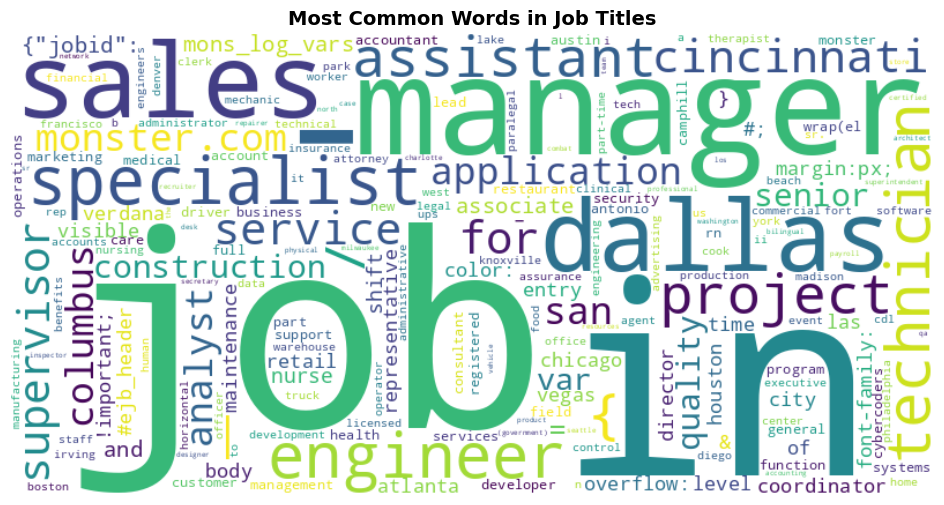

In [41]:
word_freq = Counter(" ".join(df['job_title'].dropna()).lower().split())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Job Titles", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

**Findings:**
- Words that stand out relating to jobs are Sales, Manger, Technician, Engineer, assistant as well as some others.
- This could indicate indemand jobs at the time.

In [42]:
df['salary_range'] = df['max_salary_yearly'] - df['min_salary_yearly']

In [43]:

# Select numeric features
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Focus on correlation with avg_salary
salary_corr = correlation_matrix['avg_salary'].sort_values(ascending=False)

# Display top 10 most correlated features
print(salary_corr.head(10))


avg_salary           1.000000
max_salary_yearly    0.995466
salary_bin           0.995465
min_salary_yearly    0.992948
salary_range         0.722341
salary_min           0.027781
salary_max           0.021042
Name: avg_salary, dtype: float64


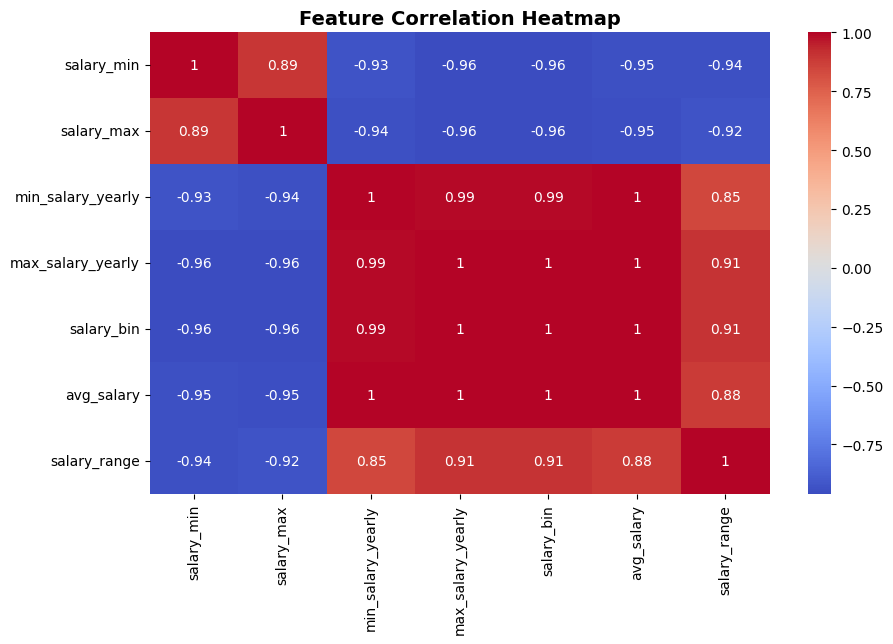

In [44]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

**Findings:**
- Numeric columns in this data are all the Salary fields so it makes sense that they are high correlated to one another or negatively correlated to the other.

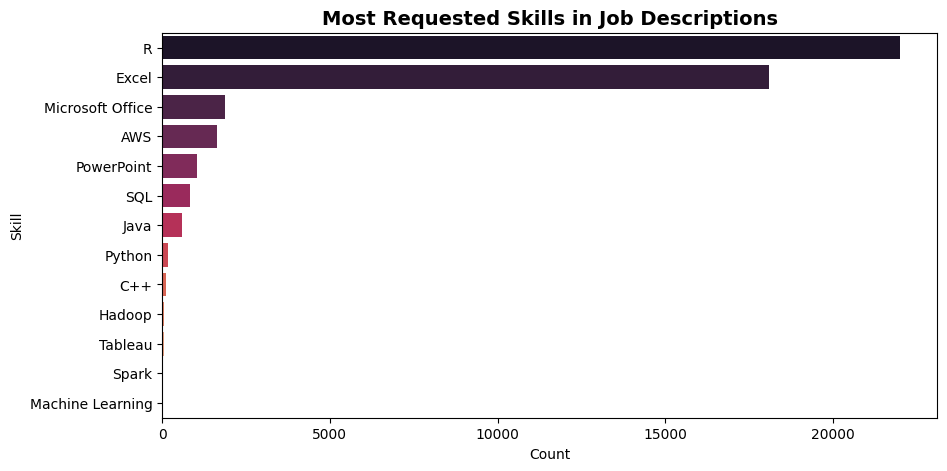

In [45]:
skills = ["Python","SQL","Excel","Tableau","R","Machine Learning","AWS","Java","C++","Hadoop","Spark", "Microsoft Office", "Excel", "PowerPoint"]
skill_counts = Counter()

for desc in df['job_description'].dropna():
    for skill in skills:
        if skill.lower() in desc.lower():
            skill_counts[skill] += 1

skill_series = pd.Series(skill_counts).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=skill_series.values, y=skill_series.index, palette="rocket", hue= skill_series.index, legend = False)
plt.title("Most Requested Skills in Job Descriptions", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Count")
plt.ylabel("Skill")
plt.show()

**Findings:**
- For ceratin skills being looked for R and Excel were some of the most common skills found.
- List could be expanded to cover skills from the other fields to get a better understanding of important skills.

## EDA Summary
Based on the various visualizations and tables above there are some clear observations to be made about the dataset that can help when moving forward to the Modeling part of the project. First, based on the missing data, Salary is not a good field to proceed with as majority of the data in that field is missing. This will result in our modeling section being more of a classification problem to categorize job_titles/job_descriptions into job_categories. Then, locations are mostly in the south with some in the midwest and other regions, while this may not play a massive role in determining various other outcomes such as job_category or job_title it is still interesting to see and be able to draw conclusions from. Next, not all of the data is categorized properly resulting in most of the fields being other. The solution will be extracting words from job_title and catergorizing them into 10 different fields.

## Feature Engineering

In [46]:
# Create job_category mapping from job_title
def map_job_category(title):
    if pd.isna(title):
        return "Other"

    title = title.lower()

    # Data / Analytics
    if any(x in title for x in ["data", "machine learning", "statistic", "bi analyst", "analytics", "analyst", "sql", "python"]):
        return "Data / Analytics"

    # Software / IT
    elif any(x in title for x in ["software", "developer", "programmer", "it", "systems", "technology", "devops", "java", "python"]):
        return "Software / IT"

    # Business / Management
    elif any(x in title for x in ["business analyst", "operations", "project manager", "program manager", "strategy", "director", "assistant"]):
        return "Business / Management"

    # Finance / Accounting
    elif any(x in title for x in ["accountant", "financial", "finance", "bank", "investment", "auditor"]):
        return "Finance / Accounting"

    # Healthcare / Medical
    elif any(x in title for x in ["nurse", "physician", "doctor", "medical", "health", "therapist", "clinical", "care", "rn", "np", "nursing"]):
        return "Healthcare / Medical"

    # Sales / Marketing
    elif any(x in title for x in ["sales", "marketing", "advertising", "brand", "account executive", "seo", "social media"]):
        return "Sales / Marketing"

    # Human Resources / Recruiting
    elif any(x in title for x in ["hr", "human resources", "recruiter", "talent", "staffing"]):
        return "Human Resources / Recruiting"

    # Engineering (Non-Software)
    elif any(x in title for x in ["mechanical", "civil", "electrical", "chemical", "manufacturing", "industrial engineer", "engineer", "welding"]):
        return "Engineering (Non-Software)"

    # Customer Service / Support
    elif any(x in title for x in ["customer service", "call center", "support", "client success", "help desk", "field technician", "field mechanic"]):
        return "Customer Service / Support"

    # Education / Training
    elif any(x in title for x in ["teacher", "professor", "instructor", "trainer", "education", "teach", "principal", "counselor"]):
        return "Education / Training"

    # Legal / Government
    elif any(x in title for x in ["attorney", "lawyer", "legal", "paralegal", "government", "policy", "public sector"]):
        return "Legal / Government"

    # Catch-all
    else:
        return "Other / Miscellaneous"

# Apply mapping
df['job_category'] = df['job_title'].astype(str).apply(map_job_category)

# Quick look
print(df['job_category'].value_counts())


job_category
Other / Miscellaneous           8107
Software / IT                   4741
Business / Management           2124
Healthcare / Medical            2058
Sales / Marketing               1513
Data / Analytics                1103
Engineering (Non-Software)       932
Customer Service / Support       477
Finance / Accounting             424
Legal / Government               210
Human Resources / Recruiting     187
Education / Training             124
Name: count, dtype: int64


**Findings:**

- Most of the jobs are still categorized as other/misc, this can skew the data towards that category, however some industries such as softwares, business and healthcare have a good amount of data wheras HR, education and legal have little to no  data which can result in those fields not being categorized properly.
- This could also mean that there are some positions that don't cover any of these areas or mean that the categories need to be more specfic.

In [47]:
# Display job titles categorized as 'Other / Miscellaneous'
other_jobs = df[df['job_category'] == 'Other / Miscellaneous']
print("Sample job titles in the 'Other / Miscellaneous' category:")
display(other_jobs['job_title'].sample(min(20, len(other_jobs)), random_state=42))

Sample job titles in the 'Other / Miscellaneous' category:


,job_title
11594,Experienced Apartment Manager for Tower at Rya...
3582,Dental Specialist Job in Lonoke body { margin...
21975,Customer Business Manager Job in Cincinnati
10905,Entry Level Account Management Job in San Diego
3860,Monster
9865,Production Labor / Bag Line - Aberdeen
8753,Warehouse Team Lead Job in Atlanta
14933,Hotel Breakfast Server Job in Baton Rouge
1563,Auto Parts Counter Job in Doylestown
7393,Line Cook Job in Knoxville


**Findings:**
- Some of the jobs listed here are not covered in the categories made before
- Could increase the amount of categories to try and filter all positions but might still cause problems if there aren't enough jobs in each category.

Job Category Counts:
 job_category
Other / Miscellaneous           8107
Software / IT                   4741
Business / Management           2124
Healthcare / Medical            2058
Sales / Marketing               1513
Data / Analytics                1103
Engineering (Non-Software)       932
Customer Service / Support       477
Finance / Accounting             424
Legal / Government               210
Human Resources / Recruiting     187
Education / Training             124
Name: count, dtype: int64

Percentage Distribution:
 job_category
Other / Miscellaneous           36.85
Software / IT                   21.55
Business / Management            9.65
Healthcare / Medical             9.35
Sales / Marketing                6.88
Data / Analytics                 5.01
Engineering (Non-Software)       4.24
Customer Service / Support       2.17
Finance / Accounting             1.93
Legal / Government               0.95
Human Resources / Recruiting     0.85
Education / Training             0.56

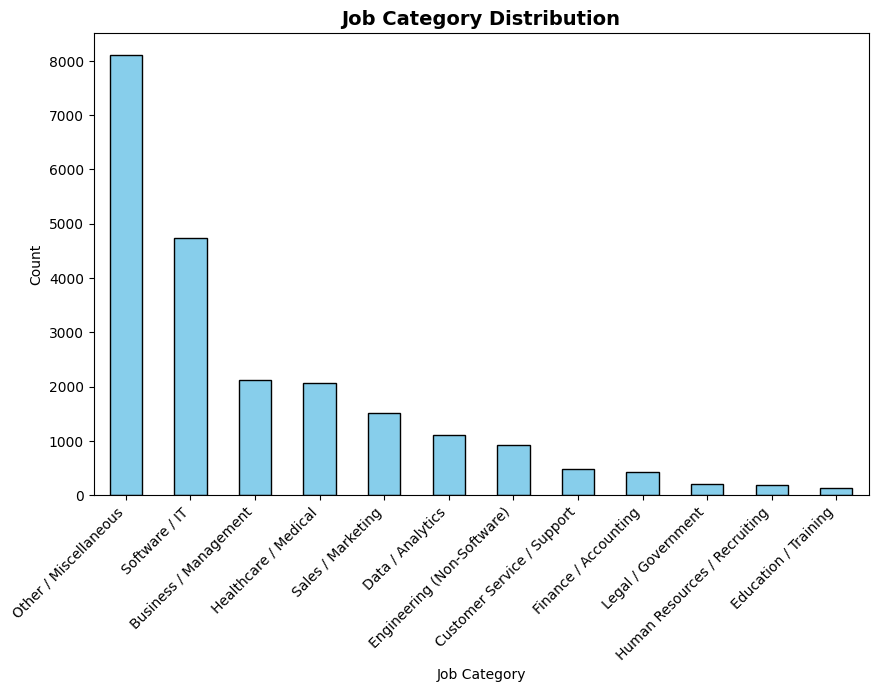

In [48]:
# Count categories
category_counts = df['job_category'].value_counts()

# Print raw counts
print("Job Category Counts:\n", category_counts)

# Percentage distribution
print("\nPercentage Distribution:\n", (category_counts / len(df) * 100).round(2))

# Plot distribution
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Job Category Distribution",fontdict={'fontsize': 14, 'fontweight': 'bold'} )
plt.xlabel("Job Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()


# Model Creation

In [49]:
#imports for models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout
from keras.preprocessing.sequence import pad_sequences
# XGBoost (make sure xgboost is installed)
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

import joblib
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Necessary Imports to create various models such as RandomForest, XGBoost, and LogisticRegression as well as encoding the data

In [50]:
# --- Target ---
TARGET = "job_category"
assert TARGET in df.columns, f"Expected target column '{TARGET}' in df."

y = df[TARGET].copy()

# --- Feature columns ---
# Text feature (use the richest text field you have)
TEXT_COL = "job_description" if "job_description" in df.columns else "job_title"
assert TEXT_COL in df.columns, "Need 'job_description' or 'job_title' in df."

# Categorical metadata (only add if present)
CATEGORICAL_CANDIDATES = ["state_clean", "company", "city", "organization", "sector"]
categorical_features = [c for c in CATEGORICAL_CANDIDATES if c in df.columns]

# Build X with only features (never include target!)
feature_cols = [TEXT_COL] + categorical_features
X = df[feature_cols].copy()

print("Features used:", feature_cols)
print("Target:", TARGET)


Features used: ['job_description', 'state_clean', 'city', 'organization', 'sector']
Target: job_category


For this modeling section, the target feature will be job_category and the features used to predict this will be features that are not mostly empty as mentioned above when discussing the null/missing values.

In [51]:
from sklearn.preprocessing import LabelEncoder

# Encode y once
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# New train/test split (replace old one)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


Using Label Encoding to format string values into numeric format for machine learning models

In [52]:
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (17600, 5) Test size: (4400, 5)


In [53]:
# Text and categorical preprocessors
text_tf = TfidfVectorizer(
    max_features=5000,    # keep runtime reasonable
    ngram_range=(1,2),
    min_df=2,
    stop_words="english"
)

cat_ohe = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_tf, TEXT_COL),
        ("cat", cat_ohe, categorical_features)
    ],
    remainder="drop",
    sparse_threshold=0.3
)

In [54]:
#Apply vectorizer to X data
X_train_tfidf = text_tf.fit_transform(X_train[TEXT_COL])
X_test_tfidf = text_tf.transform(X_test[TEXT_COL])

Applying vectorizer towards the data to transform the data. Also using OneHotEncoder to handle the data and be better suited for the RandomForest and XGBoost models

### Logistic Regression

In [55]:
#Creating logistic regression model
log_reg_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1 if "n_jobs" in LogisticRegression().get_params() else None
    ))
])

In [56]:
#Fitting training data and predicting test data
log_reg_pipeline.fit(X_train, y_train)
y_pred = log_reg_pipeline.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0      0.565     0.706     0.628       425
           1      0.379     0.674     0.485        95
           2      0.525     0.756     0.620       221
           3      0.333     0.800     0.471        25
           4      0.473     0.747     0.579       186
           5      0.554     0.847     0.670        85
           6      0.634     0.731     0.679       412
           7      0.323     0.568     0.412        37
           8      0.424     0.857     0.567        42
           9      0.793     0.583     0.672      1621
          10      0.634     0.884     0.738       303
          11      0.686     0.477     0.563       948

    accuracy                          0.633      4400
   macro avg      0.527     0.719     0.590      4400
weighted avg      0.672     0.633     0.634      4400



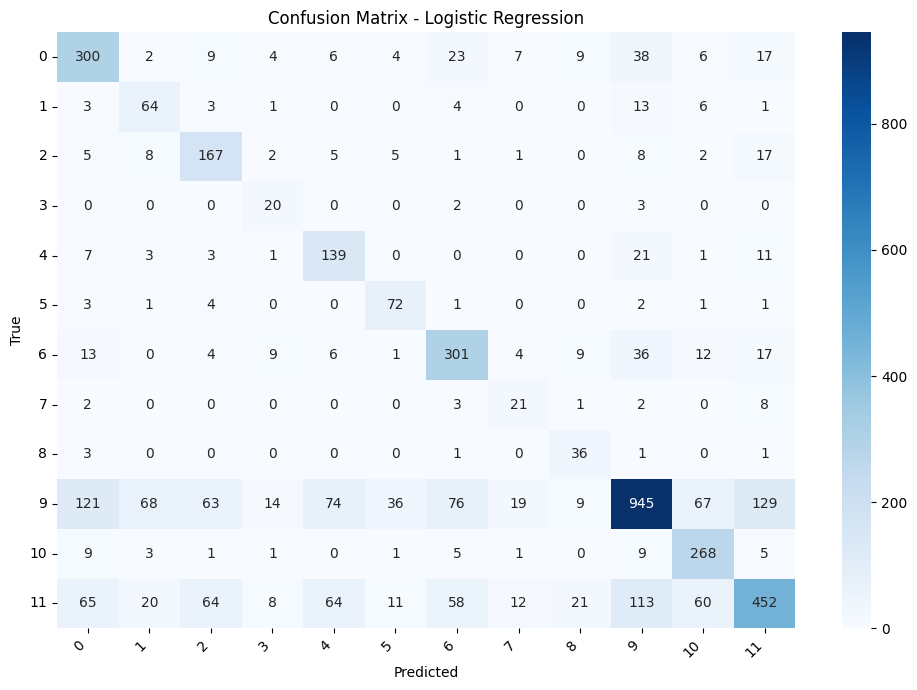

In [57]:
#Print metrics on model performance
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=log_reg_pipeline.classes_)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=log_reg_pipeline.classes_, yticklabels=log_reg_pipeline.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Findings:**
- Overall performance is good but not spectacular as there are some job_categories being misclassified
- This can be due to not enough data from in those other fields. Could also be because the fields also have similar skills or job_descriptions.
- Categories 9 and 11 have the most that are misclassified with every other category

### Random Forest Model

In [58]:
#Create RandomForest model
rf_clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

Create and initialize the RandomForest Classifier

In [59]:
#Fit train data, and predict test data
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=3))

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0      0.815     0.520     0.635       425
           1      0.865     0.337     0.485        95
           2      0.829     0.638     0.721       221
           3      0.667     0.320     0.432        25
           4      0.805     0.489     0.609       186
           5      0.819     0.694     0.752        85
           6      0.723     0.646     0.682       412
           7      0.562     0.243     0.340        37
           8      0.532     0.595     0.562        42
           9      0.619     0.895     0.732      1621
          10      0.807     0.802     0.805       303
          11      0.682     0.467     0.554       948

    accuracy                          0.679      4400
   macro avg      0.727     0.554     0.609      4400
weighted avg      0.701     0.679     0.667      4400



In [60]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate Random Forest
rf_cv_scores = cross_val_score(rf_clf, X, y_encoded, cv=cv, scoring="accuracy")
print("Random Forest CV Mean Accuracy:", rf_cv_scores.mean())
print("Random Forest CV Scores:", rf_cv_scores)

Random Forest CV Mean Accuracy: 0.6739545454545454
Random Forest CV Scores: [0.6825     0.67409091 0.68227273 0.67340909 0.6575    ]


RF — Accuracy: 0.6790909090909091
RF — Macro F1: 0.608999064082648

Classification report (RF):
               precision    recall  f1-score   support

           0      0.815     0.520     0.635       425
           1      0.865     0.337     0.485        95
           2      0.829     0.638     0.721       221
           3      0.667     0.320     0.432        25
           4      0.805     0.489     0.609       186
           5      0.819     0.694     0.752        85
           6      0.723     0.646     0.682       412
           7      0.562     0.243     0.340        37
           8      0.532     0.595     0.562        42
           9      0.619     0.895     0.732      1621
          10      0.807     0.802     0.805       303
          11      0.682     0.467     0.554       948

    accuracy                          0.679      4400
   macro avg      0.727     0.554     0.609      4400
weighted avg      0.701     0.679     0.667      4400



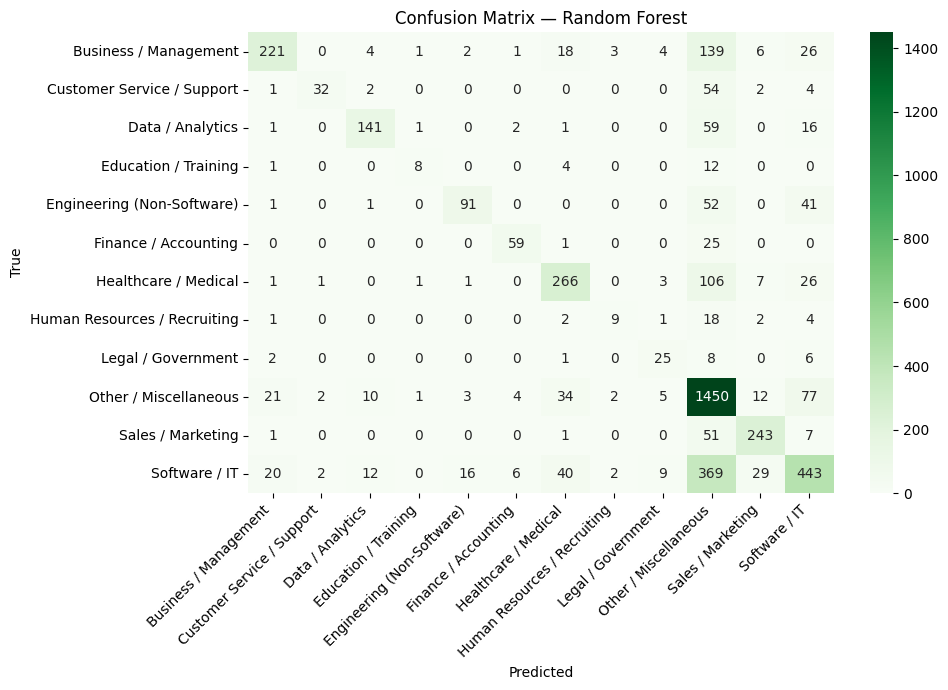

In [61]:
#Print netruc scores and confusion matrix
print("RF — Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF — Macro F1:", f1_score(y_test, y_pred_rf, average="macro"))
print("\nClassification report (RF):\n", classification_report(y_test, y_pred_rf, digits=3))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_clf.classes_)
plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

In [62]:
# Detailed class-by-class metrics
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, average=None)

print("\n🔹 Detailed Metrics per Class (XGBoost)")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: Precision={prec[i]:.2f}, Recall={rec[i]:.2f}, F1={f1[i]:.2f}")



🔹 Detailed Metrics per Class (XGBoost)
Business / Management: Precision=0.82, Recall=0.52, F1=0.64
Customer Service / Support: Precision=0.86, Recall=0.34, F1=0.48
Data / Analytics: Precision=0.83, Recall=0.64, F1=0.72
Education / Training: Precision=0.67, Recall=0.32, F1=0.43
Engineering (Non-Software): Precision=0.81, Recall=0.49, F1=0.61
Finance / Accounting: Precision=0.82, Recall=0.69, F1=0.75
Healthcare / Medical: Precision=0.72, Recall=0.65, F1=0.68
Human Resources / Recruiting: Precision=0.56, Recall=0.24, F1=0.34
Legal / Government: Precision=0.53, Recall=0.60, F1=0.56
Other / Miscellaneous: Precision=0.62, Recall=0.89, F1=0.73
Sales / Marketing: Precision=0.81, Recall=0.80, F1=0.80
Software / IT: Precision=0.68, Recall=0.47, F1=0.55


**Findings:**
- Better performance than the Logisitic Regression Model
- Classifies better in all areas as compared to the Logistic Regression Model
- Software/IT and Other get misclassified which can be due to the filtering done before or certain skills might transfer to other areas.

### XGBoost

In [63]:
#Create XGBoost classifier
xgb_clf = XGBClassifier(
    objective="multi:softmax",
    num_class=len(label_encoder.classes_),
    eval_metric="mlogloss",
    learning_rate=0.1,
    n_estimators=100,   # reduce from 300
    max_depth=5,        # reduce from 8
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"  # MUCH faster than default
)



In [64]:
#Fit model on train data
xgb_clf.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1, num_class=12, ...)

In [65]:
#Predict test data
y_pred_xgb = xgb_clf.predict(X_test_tfidf)

XGB — Accuracy: 0.6997727272727273
XGB — Macro F1: 0.6532171251814217

Classification report (XGB):
               precision    recall  f1-score   support

           0      0.683     0.701     0.692       425
           1      0.754     0.453     0.566        95
           2      0.794     0.715     0.752       221
           3      0.900     0.360     0.514        25
           4      0.759     0.645     0.698       186
           5      0.893     0.788     0.838        85
           6      0.724     0.617     0.666       412
           7      0.550     0.297     0.386        37
           8      0.571     0.667     0.615        42
           9      0.665     0.857     0.749      1621
          10      0.749     0.835     0.789       303
          11      0.727     0.474     0.573       948

    accuracy                          0.700      4400
   macro avg      0.731     0.617     0.653      4400
weighted avg      0.708     0.700     0.691      4400



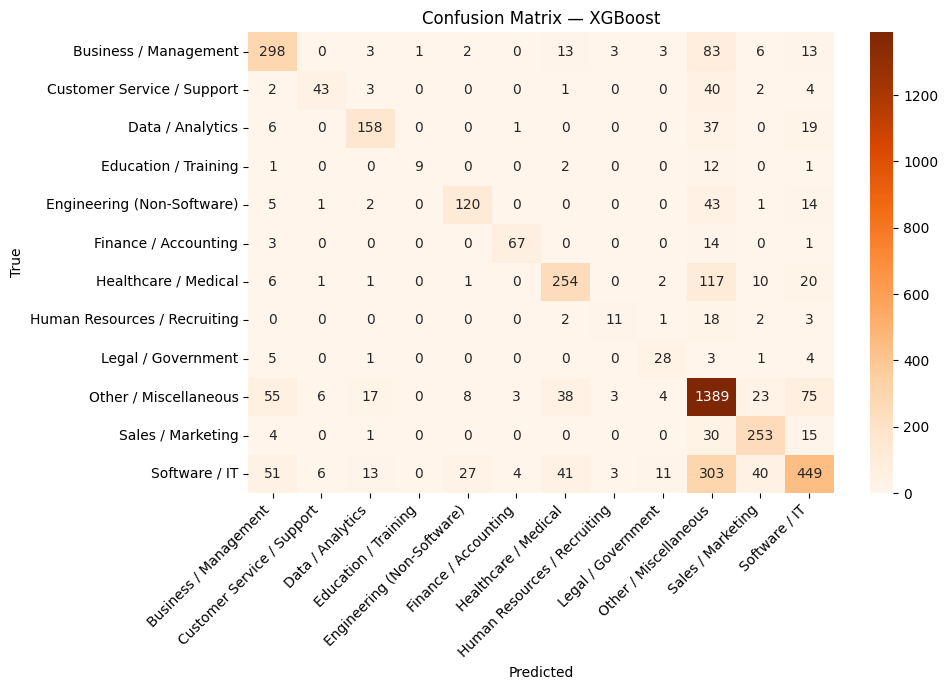

In [66]:
# Evaluate on test

print("XGB — Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGB — Macro F1:", f1_score(y_test, y_pred_xgb, average="macro"))
print("\nClassification report (XGB):\n", classification_report(y_test, y_pred_xgb, digits=3))

cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=xgb_clf.classes_)
plt.figure(figsize=(10,7))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix — XGBoost")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

In [67]:
from sklearn.metrics import precision_recall_fscore_support

# Detailed class-by-class metrics
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average=None)

print("\n🔹 Detailed Metrics per Class (XGBoost)")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: Precision={prec[i]:.2f}, Recall={rec[i]:.2f}, F1={f1[i]:.2f}")



🔹 Detailed Metrics per Class (XGBoost)
Business / Management: Precision=0.68, Recall=0.70, F1=0.69
Customer Service / Support: Precision=0.75, Recall=0.45, F1=0.57
Data / Analytics: Precision=0.79, Recall=0.71, F1=0.75
Education / Training: Precision=0.90, Recall=0.36, F1=0.51
Engineering (Non-Software): Precision=0.76, Recall=0.65, F1=0.70
Finance / Accounting: Precision=0.89, Recall=0.79, F1=0.84
Healthcare / Medical: Precision=0.72, Recall=0.62, F1=0.67
Human Resources / Recruiting: Precision=0.55, Recall=0.30, F1=0.39
Legal / Government: Precision=0.57, Recall=0.67, F1=0.62
Other / Miscellaneous: Precision=0.66, Recall=0.86, F1=0.75
Sales / Marketing: Precision=0.75, Recall=0.83, F1=0.79
Software / IT: Precision=0.73, Recall=0.47, F1=0.57


**Findings:**
- This model performed very similarly to the Random Forest model
- Some areas were classified better in the Random Forest model
- Outperforms the metrics and results of the Logistic Regression
- Metric Scores are either higher or similar as compared to the RandomForest Model

#Results

In [68]:
#Display results on all models
results = []
results.append({"model":"LogReg", "accuracy": accuracy_score(y_test, y_pred), "macro_f1": f1_score(y_test, y_pred, average="macro")})
results.append({"model":"RandomForest", "accuracy": accuracy_score(y_test, y_pred_rf), "macro_f1": f1_score(y_test, y_pred_rf, average="macro")})
results.append({"model":"XGBoost", "accuracy": accuracy_score(y_test, y_pred_xgb), "macro_f1": f1_score(y_test, y_pred_xgb, average="macro")})

results_df = pd.DataFrame(results).sort_values(by="macro_f1", ascending=False)
results_df


,model,accuracy,macro_f1
2,XGBoost,0.699773,0.653217
1,RandomForest,0.679091,0.608999
0,LogReg,0.632955,0.590166


Overall performance metrics indicate that the XGBoost model was best, RandomForest was second, and the Logistic Regression model performed the worst

In [69]:
#save the xgboost model since it performed the best
joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump(xgb_clf, "xgb_model.joblib")
joblib.dump(label_encoder, "label_encoder.joblib")
print("Saved: preprocessor.joblib, xgb_model.joblib, label_encoder.joblib")


Saved: preprocessor.joblib, xgb_model.joblib, label_encoder.joblib


In [70]:
#Use model to predict data
def predict_job_category(model, text, state=None, company=None, city=None, organization=None, sector=None):
    # Create a dictionary with all expected features, including placeholders for missing ones
    sample = {TEXT_COL: text}

    # Add categorical features, using provided values or None
    expected_categorical_features = ["state_clean", "company", "city", "organization", "sector"]
    for cat_col in expected_categorical_features:
        if cat_col == "state_clean":
            sample[cat_col] = state
        elif cat_col == "company":
            sample[cat_col] = company
        elif cat_col == "city":
            sample[cat_col] = city
        elif cat_col == "organization":
            sample[cat_col] = organization
        elif cat_col == "sector":
            sample[cat_col] = sector
        # Ensure all categorical columns expected by the preprocessor are present
        if cat_col not in sample:
             sample[cat_col] = None


    X_sample = pd.DataFrame([sample])

    # Pipeline model:
    if isinstance(model, Pipeline):
        return model.predict(X_sample)[0]

    # XGB path:
    prep = joblib.load("preprocessor.joblib")
    enc = joblib.load("label_encoder.joblib")
    X_mat = prep.transform(X_sample)
    y_pred_enc = xgb_clf.predict(X_mat)
    return enc.inverse_transform(y_pred_enc)[0]

# Example:
example_text = "We are seeking a data analyst with SQL, Python, Tableau to deliver insights to business stakeholders."
print("Predicted:", predict_job_category(rf_clf, example_text, state="CA", company="Acme Inc."))

Predicted: 2


## Final Summary

In conclusion, this project helps answer all the questions we sought out to solve and helps to identify job categories based on description and other fields. Business and Tech were the top job categories during 2016, skills in demand from the list created indicated R and Excel were top indemand skills. Finally, not all jobs had posted salaries for positions making it harder to gain a complete understanding but what can be noticed from job postings with salaries is while there are fluctuations in salaries but the most common salary present in the dataset was 100k with 140 people. There was some bias in the dataset that can alter and manipulate our end results such as, all the data being from Monster this is not the only job posting website available which indicates these were not all the jobs posted during 2016. In addition there is not an equal split of data depending on region which means other features such as salary can be skewed towards areas where minimum wage or cost of living is lower than other regions such as Northeast, which can alter the results found.

Through the modeling section, it was clear that the XGBoost model was the overall best performing model, however it can still be improved upon and increase its effectiveness in classifying jobs based on descriptions. With fine-tuning parameters all the models tested can improved results and be better at classifying this data.

Future adaptations of this project include, utilizing an external dataset/api to test model performance, create an application to help filter jobs based on categories, and expand the feature engineering section to include more job types and be able to remove the other category. This type of application can help companies determine up and coming trends such as job positions and necessary skills.

